# cml1 - Immobilienrechner
# 2.2 Bestmögliches Regressionsmodell - kaggle-Contest

Entwickle mit beliebigen Algorithmen das bestmögliche Modell im Sinne des Mean absolute percentage error (MAPE). Vergleiche dabei mindestens drei algorithmische Ansätze, wobei ein multiples lineares Modell Teil davon sein soll als Benchmark. Untersuche die ‘Variable Importance’ für dein bestes Modell.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf, welche die Entwicklung deines besten Modells, sowie der zwei weiteren Modelle dokumentiert, inklusive verwendeter Features, Preprocessing, Model Selection Prozess und Untersuchung der ‘Variable Importance’.

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.

### MAPE - Metrik

Der Mean Absolute Percentage Error (MAPE) ist eine Metrik zur Beurteilung der Genauigkeit von Vorhersagemodellen. MAPE gibt den durchschnittlichen prozentualen Fehler zwischen den beobachteten (tatsächlichen) Werten und den vorhergesagten Werten an. Er wird häufig in der Zeitreihenanalyse und bei Prognosemodellen verwendet, besonders wenn es wichtig ist, die Genauigkeit von Vorhersagen in Bezug auf die tatsächlichen Werte in Prozent auszudrücken.

Die Formel zur Berechnung von MAPE ist:

$$MAPE = \frac{1}{n} \sum_{i=1}^{n}\frac{|y_i - \hat{y}_i|}{y_i}* 100$$

wobei: 
- $y_i$ der tatsächliche Wert zum Zeitpunkt t ist.
- $\hat{y}_i$ der vorhergesagte Wert zum Zeitpunkt t ist.
- $n$ die Gesamtanzahl der Beobachtungen ist.

## Module importieren

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# tree models
from sklearn.tree import DecisionTreeRegressor

# ensemble models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# xgb model
import xgboost as xgb
from xgboost import XGBRegressor

# imputing
from sklearn.impute import SimpleImputer, KNNImputer

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

# pipeline
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV

# metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

## Daten laden

In [140]:
df_raw = pd.read_csv('../../../data/immo_data_clean.csv', low_memory=False)
print(df_raw.shape)

(17858, 57)


## Daten vorbereiten

In [141]:
df_raw.describe()

,price_cleaned,Zip,Year built:,Living_area_unified,Floor_unified,Floor_space_merged,Plot_area_unified,Rooms_new,gde_workers_sector1,gde_workers_sector2,...,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,ForestDensityL,ForestDensityM,ForestDensityS
count,1.785800e+04,17858.000000,5618.000000,17140.000000,8467.000000,2408.000000,6234.000000,17428.000000,17858.000000,17858.000000,...,17858.000000,17858.000000,17858.000000,17858.000000,17858.000000,17858.000000,17858.000000,17858.000000,17858.000000,17858.000000
mean,1.062251e+06,3739.600571,1991.089890,146.954259,4.419983,180.894103,968.532243,4.966433,108.498376,1393.858943,...,0.342865,0.025770,0.013395,0.004246,0.084643,0.124945,0.170645,0.184874,0.120151,0.076678
std,5.707972e+05,2479.737810,54.588182,84.516783,53.106722,124.421777,5598.271534,1.820539,115.929810,2805.840886,...,0.218547,0.066226,0.044401,0.024252,0.114463,0.153786,0.208404,0.197110,0.176784,0.162131
min,3.850000e+05,1000.000000,1400.000000,5.000000,-4.000000,4.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000e+05,1802.000000,1981.250000,100.000000,0.000000,110.000000,335.000000,3.500000,30.000000,149.000000,...,0.173043,0.000000,0.000000,0.000000,0.024300,0.038974,0.052060,0.023658,0.000000,0.000000
50%,8.900000e+05,2710.000000,2011.000000,130.000000,1.000000,151.000000,592.000000,4.500000,68.000000,461.000000,...,0.311133,0.000000,0.000000,0.000000,0.048405,0.072024,0.090417,0.113456,0.028412,0.000000
75%,1.340000e+06,5735.000000,2022.000000,170.000000,2.000000,220.000000,988.000000,5.500000,149.000000,1328.000000,...,0.494586,0.019221,0.000000,0.000000,0.091458,0.136092,0.181103,0.289574,0.176214,0.041872
max,2.960000e+06,9658.000000,2025.000000,4362.000000,999.000000,2233.000000,350917.000000,26.000000,754.000000,36333.000000,...,1.000000,0.524478,0.503653,0.443123,0.856142,0.939104,1.000000,0.896966,0.999453,1.000000


In [142]:
# Identify columns with object dtype
categorical_columns = df_raw.select_dtypes(include=['object']).columns.tolist()

# Identify columns with numerical dtype
numerical_columns = df_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Convert to dummy variables
df_raw = pd.get_dummies(df_raw, columns=categorical_columns, drop_first=True, dtype=int)
df_raw.shape

(17858, 104)

Durch die Erzeugung von Dummies für die kategorischen Spalten haben wir nun 104 Spalten. Um Ausreisser zu entfernen, werden wir die Daten auf den Bereich zwischen dem 1% und 99% Quantil beschränken.

In [143]:
df = df_raw.copy()

# Compute the 1% and 99% quantiles for each numerical column
quantiles_1 = df[numerical_columns].quantile(0.015)
quantiles_99 = df[numerical_columns].quantile(0.985)

# Replace outliers in the original data with NaN values
for column in numerical_columns:
    condition = (df[column] < quantiles_1[column]) | (df[column] > quantiles_99[column])
    df.loc[condition, column] = None

# Remove all na rows in the target column
df = df.dropna(subset=['price_cleaned'], axis=0)
df.shape

(17420, 104)

## Korrelationen

In diesem Abschnitt werden wir hochkorrelierte Merkmale identifizieren. Dies ist ein wichtiger Schritt bei der Auswahl von Merkmalen. Die Logik dahinter ist, dass zwei (oder mehr) Variablen, die hoch korreliert sind, redundante Informationen enthalten, was für einige Algorithmen des maschinellen Lernens, insbesondere die lineare Regression, problematisch sein kann.

Der Code berechnet die paarweise Korrelationsmatrix aller Spalten im DataFrame. Anschließend wird das untere Dreieck dieser Matrix durchlaufen, um Spaltenpaare zu ermitteln, die einen absoluten Korrelationswert von mehr als 0.8 haben. Für jedes solche Paar werden die Namen der beiden Spalten und ihr Korrelationswert in die Liste `highly_correlated_pairs` aufgenommen. Das Ergebnis ist eine Liste von Tupeln, wobei jedes Tupel zwei Spaltennamen enthält, die ein Paar hoch korrelierter Merkmale und deren spezifischen Korrelationskoeffizienten angeben.

In [144]:
def get_highly_correlated_features(df, threshold):
    correlation_matrix = df.corr()
    highly_correlated_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                highly_correlated_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))
    return highly_correlated_pairs

highly_correlated_features = get_highly_correlated_features(df, 0.75)
highly_correlated_features.sort(key=lambda x: abs(x[2]), reverse=True)
highly_correlated_features

[('gde_private_apartments', 'gde_population', 0.9984142079122033),
 ('gde_workers_total', 'gde_workers_sector3', 0.996492692291221),
 ('gde_private_apartments', 'gde_workers_total', 0.9839960846716621),
 ('gde_private_apartments', 'gde_workers_sector3', 0.981117434360313),
 ('gde_population', 'gde_workers_total', 0.9796930728008282),
 ('gde_population', 'gde_workers_sector3', 0.9740863707543556),
 ('kanton_TI', 'gde_politics_rights', 0.9168880236602394),
 ('ForestDensityM', 'ForestDensityL', 0.9151852347318667),
 ('PopulationDensityM', 'PopulationDensityL', 0.9105408843579558),
 ('WorkplaceDensityM', 'WorkplaceDensityL', 0.907176914520155),
 ('WorkplaceDensityS', 'WorkplaceDensityM', 0.9039702095128189),
 ('gde_pop_per_km2', 'gde_area_settlement_percentage', 0.8947980759296803),
 ('NoisePollutionRoadM', 'NoisePollutionRoadL', 0.8934055408710869),
 ('ForestDensityS', 'ForestDensityM', 0.8909668332656178),
 ('PopulationDensityS', 'PopulationDensityM', 0.8484881833498928),
 ('WorkplaceDen

Wir haben mehrere Merkmale identifiziert, die eine Korrelation von mehr als 0.8 mit mindestens einem anderen Merkmal aufweisen.

### Was machen wir mit den hochkorrelierten Spalten?
1. Der einfachste Ansatz besteht darin, ein Merkmal aus jedem hochkorrelierten Paar zu entfernen. Dadurch wird die Redundanz reduziert, ohne dass eine zusätzliche Modellierung erforderlich ist.

Wir können dies bei der einfachen Regression anwenden. Die Modelle, die wir hier anwenden sind robust genug, die Kolinearität zu handhaben.

## Train Test Split

In [145]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.drop("price_cleaned", axis=1)
y_train = train["price_cleaned"]

X_test = test.drop("price_cleaned", axis=1)
y_test = test["price_cleaned"]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (13936, 103)
y_train shape:  (13936,)
X_test shape:  (3484, 103)
y_test shape:  (3484,)


## Impuation

In [146]:
cols = X_train.columns

X_train_with_na = X_train.copy()
X_test_with_na = X_test.copy()

imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(imputer.transform(X_test), columns=cols)

## Standardisierung

In [147]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

## Modelle

In [148]:
mape_lst = {}

### Modell 1: Multiple Linear Regression (Benchmark)
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Das erste Modell ist eine multiple lineare Regression und dient als Benchmark für die anderen Modelle.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


Best parameters:  {'copy_X': True, 'fit_intercept': True, 'positive': False}
MAPE: 0.2731
R2: 0.5412


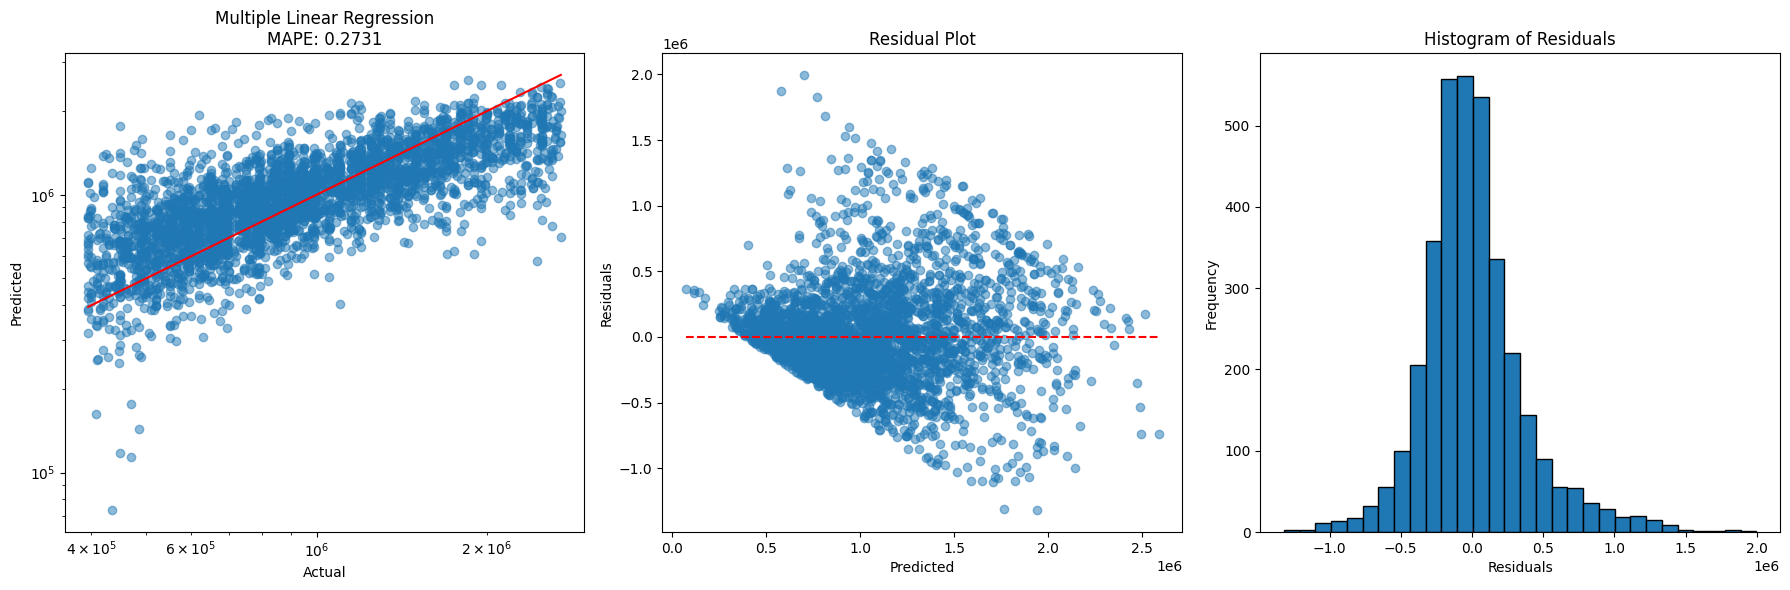

In [149]:
def mlr_model(X_train, y_train, X_test, y_test, cv=5):
    """ Creates a multiple linear regression model with grid search cv
    """
    lin_reg = LinearRegression()

    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [True, False]
    }

    grid_mlr = GridSearchCV(lin_reg, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_mlr.fit(X_train, y_train)

    best_params = grid_mlr.best_params_
    print("Best parameters: ", best_params)

    y_pred_mlr = grid_mlr.predict(X_test)

    mape_mlr = round(mean_absolute_percentage_error(y_test, y_pred_mlr), 4)
    print('MAPE: {}'.format(mape_mlr))

    r2_mlr = round(r2_score(y_test, y_pred_mlr), 4)
    print('R2: {}'.format(r2_mlr))

    plt.figure(figsize=(18, 6))
    
    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_mlr, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Multiple Linear Regression\nMAPE: {}'.format(mape_mlr))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_mlr
    
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_mlr, residuals, alpha=0.5)
    plt.hlines(0, np.min(y_pred_mlr), np.max(y_pred_mlr), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_mlr, mape_mlr

mlr_regression, mape_mlr = mlr_model(X_train, 
                           y_train, 
                           X_test, 
                           y_test, 
                           cv=5)

mape_lst['Multiple Linear Regression'] = mape_mlr

MAPE gibt her einen durchschnittlichen prozentualen Fehler von 1.77% zwischen den beobachteten (tatsächlichen) Werten und den vorhergesagten Werten an.

### Modell 2: Ridge Regression

[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


Best parameters: {'alpha': 1000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': False, 'random_state': 42}
MAPE: 0.2792
R2: 0.5325


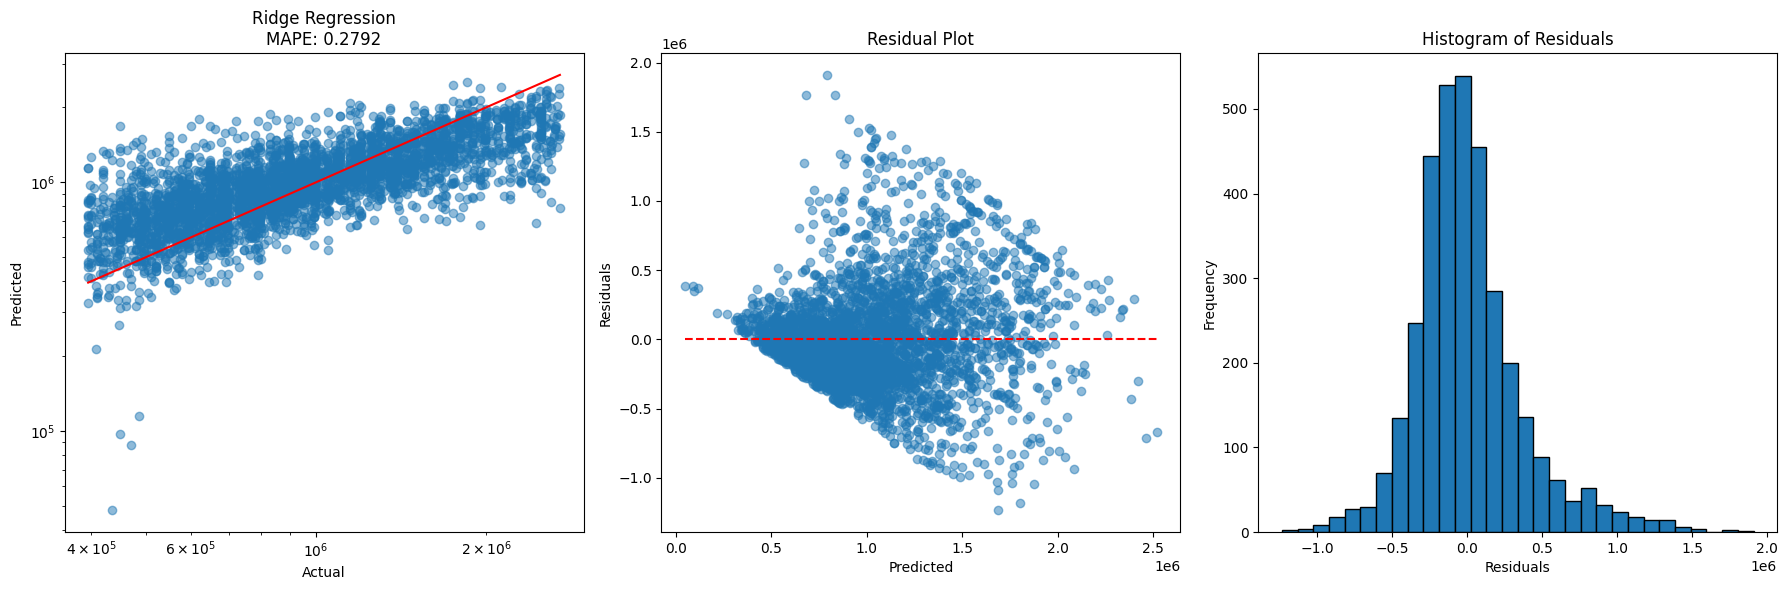

In [150]:
def ridge_model(X_train, y_train, X_test, y_test, alphas=[1], cv=5, iterations=[100]):
    """ Creates a Ridge regression model with grid search cv
    """
    ridge = Ridge()

    param_grid = {
        'alpha': alphas,
        'fit_intercept': [True],
        'positive': [False],
        'max_iter': iterations,
        'random_state': [42]
    }

    grid_ridge = GridSearchCV(ridge, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_ridge.fit(X_train, y_train)

    best_params = grid_ridge.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_ridge = grid_ridge.predict(X_test)

    mape_ridge = round(mean_absolute_percentage_error(y_test, y_pred_ridge), 4)
    print('MAPE: {}'.format(mape_ridge))

    r2_ridge = round(r2_score(y_test, y_pred_ridge), 4)
    print('R2: {}'.format(r2_ridge))

    plt.figure(figsize=(18, 6))
    
    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_ridge, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Ridge Regression\nMAPE: {}'.format(mape_ridge))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_ridge
    
    plt.subplot(1, 3, 2)

    plt.scatter(y_pred_ridge, residuals, alpha=0.5)
    plt.hlines(0, np.min(y_pred_ridge), np.max(y_pred_ridge), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_ridge, mape_ridge

ridge_regression, mape_ridge = ridge_model(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    alphas=np.linspace(1000, 20000, 400),
    cv=5,
    iterations=[100])

mape_lst['Ridge Regression'] = mape_ridge

### Modell 3: Lasso Regression
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\laeub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.385e+13, tolerance: 3.881e+11
  model = cd_fast.enet_coordinate_descent(


Best parameters: {'selection': 'cyclic', 'max_iter': 1000, 'fit_intercept': True, 'alpha': 413.6363636363636}
MAPE: 0.274
R2: 0.5401


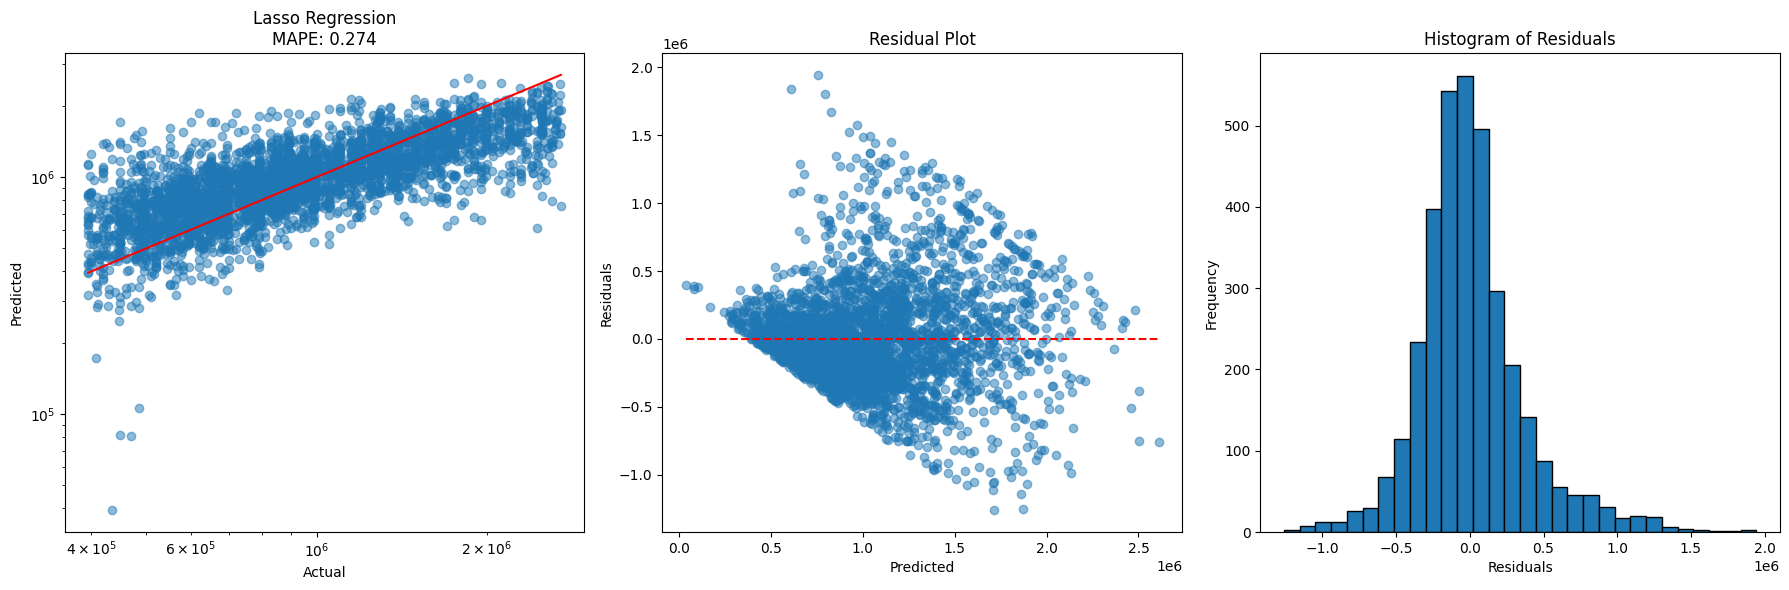

In [151]:
def lasso_model(X_train, y_train, X_test, y_test, alphas=[1], cv=5, iterations=[1000]):
    """ Creates a Lasso regression model with grid search cv
    """
    lasso = Lasso()

    param_grid = {
        'alpha': alphas,
        'fit_intercept': [True, False],
        'max_iter': iterations,
        'selection': ['random', 'cyclic']
    }

    grid_lasso = RandomizedSearchCV(lasso, param_grid, n_iter=100, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1, random_state=42)

    grid_lasso.fit(X_train, y_train)

    best_params = grid_lasso.best_params_
    print('Best parameters:', best_params)

    y_pred_lasso = grid_lasso.predict(X_test)

    mape_lasso = round(mean_absolute_percentage_error(y_test, y_pred_lasso), 4)
    print('MAPE:', mape_lasso)

    r2_lasso = round(r2_score(y_test, y_pred_lasso), 4)
    print('R2:', r2_lasso)

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_lasso, alpha=0.5)
    plot_lin = np.linspace(min(y_test), max(y_test), 100)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Lasso Regression\nMAPE: {}'.format(mape_lasso))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_lasso
    
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_lasso, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_lasso), max(y_pred_lasso), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_lasso, mape_lasso

lasso_regression, mape_lasso = lasso_model(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    alphas=np.linspace(10, 10000, 100),
    cv=5,
    iterations=[1000, 2000]
)

mape_lst['Lasso Regression'] = mape_lasso


### Modell 4: XGBoost
[Dokumentation](https://xgboost.readthedocs.io/en/latest/)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 12, 'random_state': 42}
MAPE: 0.1783
R2: 0.7234


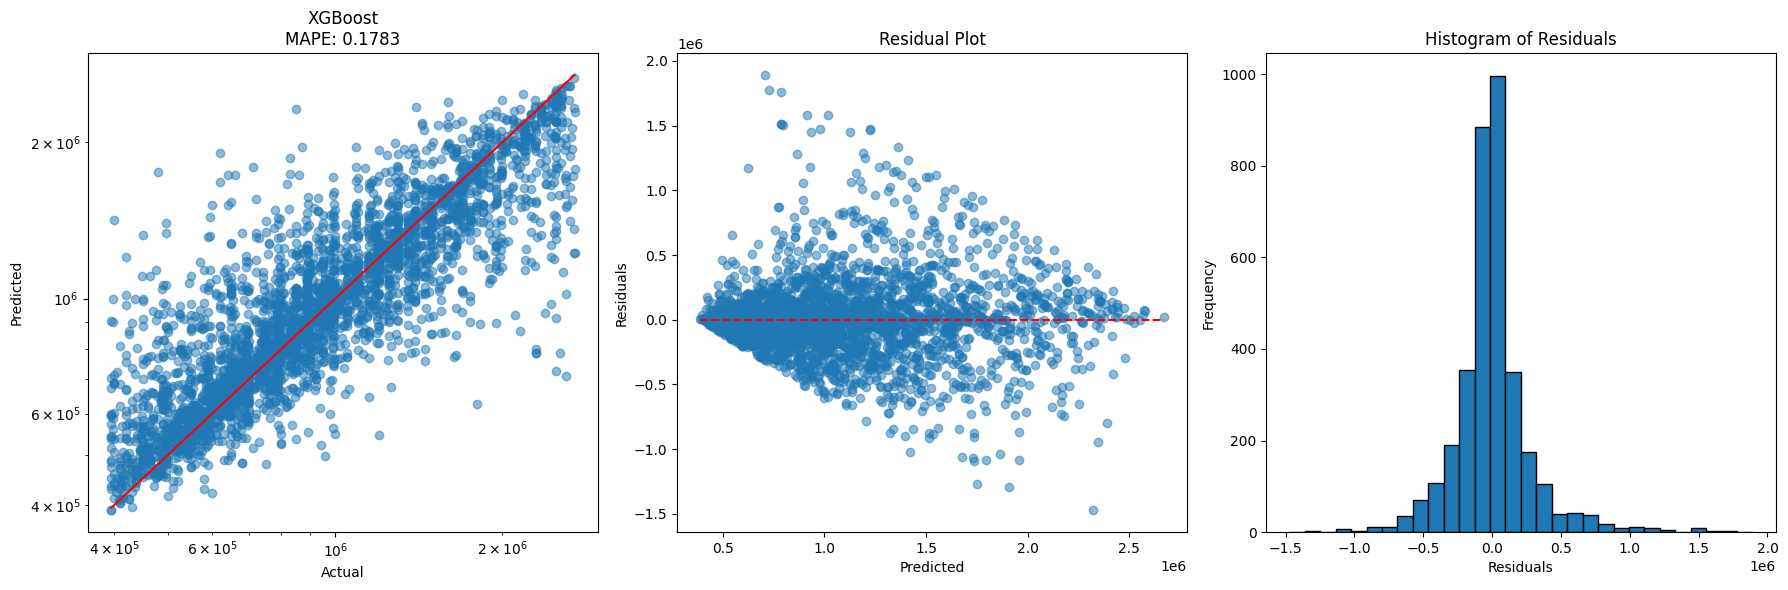

In [152]:
def xgb_model(X_train, y_train, X_test, y_test, cv=5, max_depth=[12], learning_rate=[0.1], booster=['gbtree']):
    """ Creates a XGBoost model with grid search cv
    """
    xgb = XGBRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'booster': booster,
        'random_state': [42]
    }

    grid_xgb = GridSearchCV(xgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_xgb.fit(X_train, y_train)

    best_params = grid_xgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_xgb = grid_xgb.predict(X_test)

    mape_xgb = round(mean_absolute_percentage_error(y_test, y_pred_xgb), 4)
    print('MAPE: {}'.format(mape_xgb))

    r2_xgb = round(r2_score(y_test, y_pred_xgb), 4)
    print('R2: {}'.format(r2_xgb))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_xgb, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('XGBoost\nMAPE: {}'.format(mape_xgb))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_xgb

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_xgb, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_xgb), max(y_pred_xgb), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_xgb, mape_xgb

xgb_regression, mape_xgb = xgb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    max_depth = [None, 6, 9, 12, 15],
    learning_rate = [0.1],
    booster = ['gbtree']
)

mape_lst['XGBoost'] = mape_xgb

### XGBoost Feature Importance

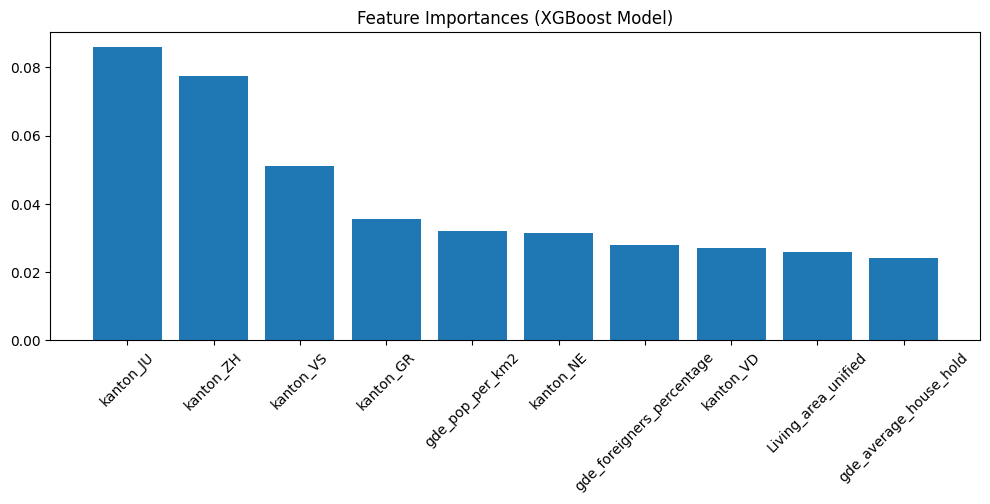

In [153]:
# Extract the best estimator from the GridSearchCV object
best_xgb_model = xgb_regression.best_estimator_

# Get feature importances
importances = best_xgb_model.feature_importances_.argsort()[::-1][:10]

# add to dataframe
feature_importances = pd.DataFrame({'feature': X_train.columns[importances], 'importance': best_xgb_model.feature_importances_[importances]})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 4))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importances (XGBoost Model)')
plt.show()

### Modell 5: Random Forest
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'random_state': 42}
MAPE: 0.1892
R2: 0.7161


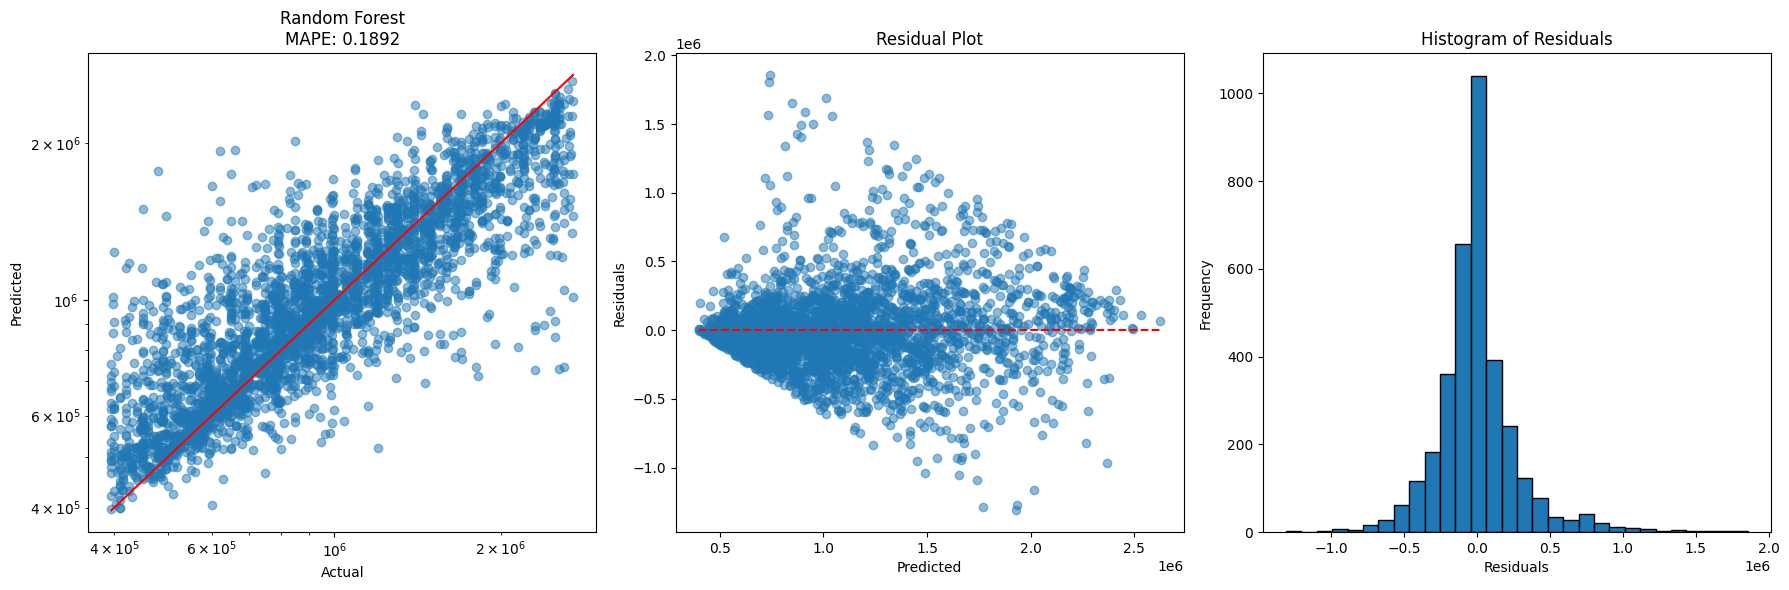

In [154]:
def rf_model(X_train, y_train, X_test, y_test, cv=5):
    """ Creates a Random Forest model with grid search cv
    """
    rf = RandomForestRegressor()

    param_grid = {
        'random_state': [42]
    }

    grid_rf = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_rf.fit(X_train, y_train)

    best_params = grid_rf.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_rf = grid_rf.predict(X_test)

    mape_rf = round(mean_absolute_percentage_error(y_test, y_pred_rf), 4)
    print('MAPE: {}'.format(mape_rf))

    r2_rf = round(r2_score(y_test, y_pred_rf), 4)
    print('R2: {}'.format(r2_rf))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_rf, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest\nMAPE: {}'.format(mape_rf))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_rf

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_rf, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_rf), max(y_pred_rf), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_rf, mape_rf

rf_regression, mape_rf = rf_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
)

mape_lst['Random Forest'] = mape_rf

### Random Forest Feature Importance

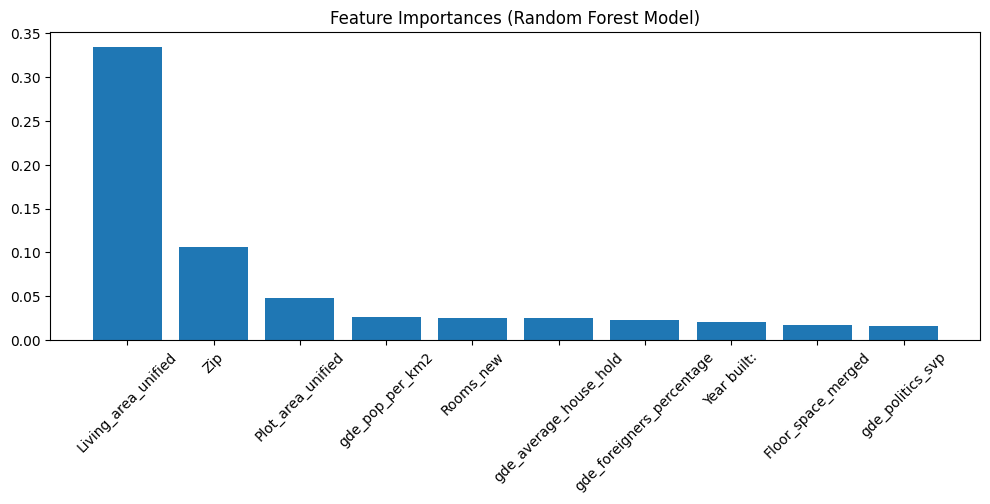

In [155]:
# feature importances for random forest
best_rf_model = rf_regression.best_estimator_.feature_importances_.argsort()[::-1][:10]

# add to dataframe
feature_importances = pd.DataFrame({'feature': X_train.columns[best_rf_model], 'importance': rf_regression.best_estimator_.feature_importances_[best_rf_model]})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 4))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importances (Random Forest Model)')
plt.show()

### Modell 6: Hist Gradient Boosting Regression
[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 20, 'random_state': 42}
MAPE: 0.1962
R2: 0.7219


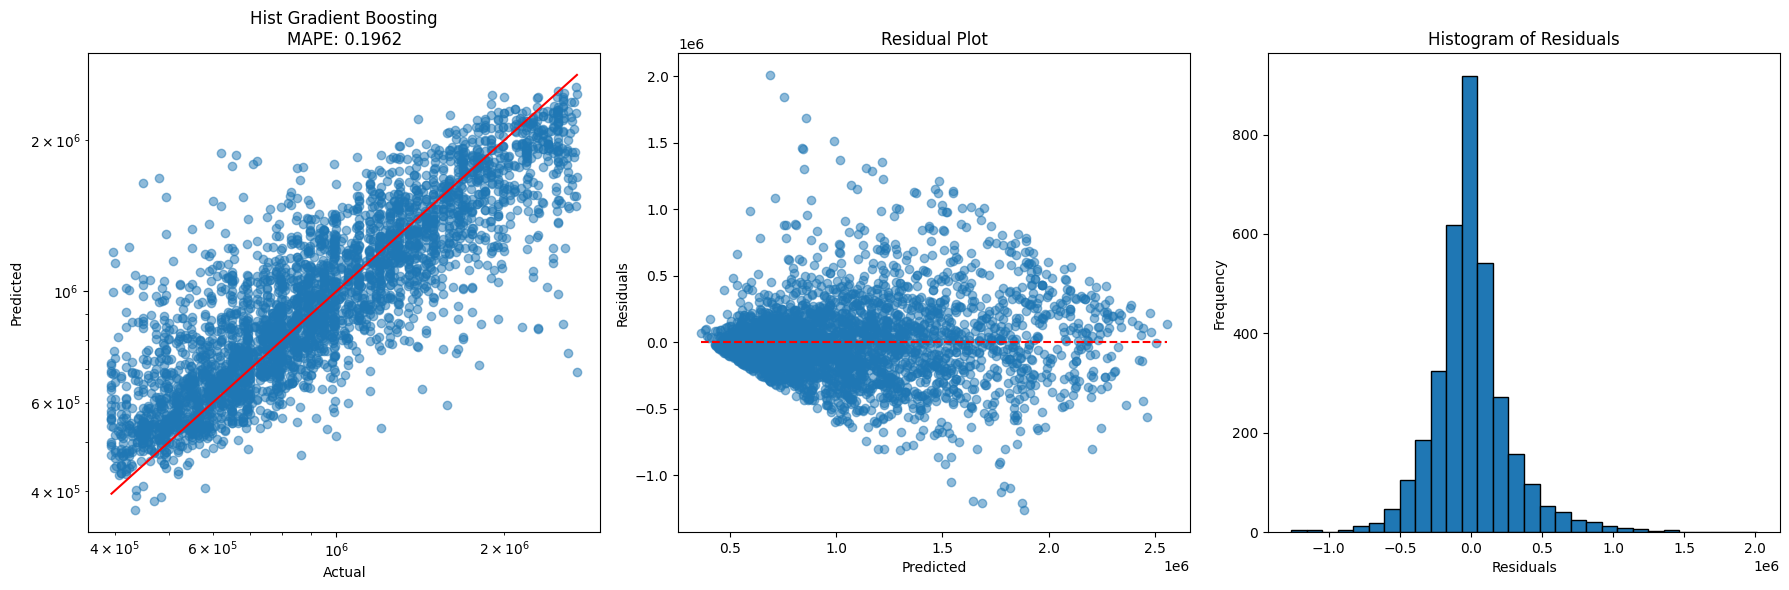

In [156]:
def hgb_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv=5, 
        max_depth=[None], 
        learning_rate=[0.1], 
        l2_regularization=[0.0], 
        max_leaf_nodes=[31],
        min_samples_leaf=[20]):
    
    """ Creates a Hist Gradient Boosting model with grid search cv
    """
    hgb = HistGradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'l2_regularization': l2_regularization,
        'max_leaf_nodes': max_leaf_nodes,
        'min_samples_leaf': min_samples_leaf,
        'random_state': [42]
    }

    grid_hgb = GridSearchCV(hgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_hgb.fit(X_train, y_train)

    best_params = grid_hgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_hgb = grid_hgb.predict(X_test)

    mape_hgb = round(mean_absolute_percentage_error(y_test, y_pred_hgb), 4)
    print('MAPE: {}'.format(mape_hgb))

    r2_hgb = round(r2_score(y_test, y_pred_hgb), 4)
    print('R2: {}'.format(r2_hgb))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_hgb, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Hist Gradient Boosting\nMAPE: {}'.format(mape_hgb))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_hgb

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_hgb, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_hgb), max(y_pred_hgb), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_hgb, mape_hgb

hgb_regression, mape_hgb = hgb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5,
    max_depth = [None, 3, 6, 9],
    learning_rate = [0.1],
    l2_regularization = [0.0, 0.1],
    max_leaf_nodes = [31, 50],
    min_samples_leaf = [20, 50],
)

mape_lst['Hist Gradient Boosting'] = mape_hgb

### Modell 7: Gradient Boosting Regression

[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'random_state': 42}
MAPE: 0.2224
R2: 0.5315


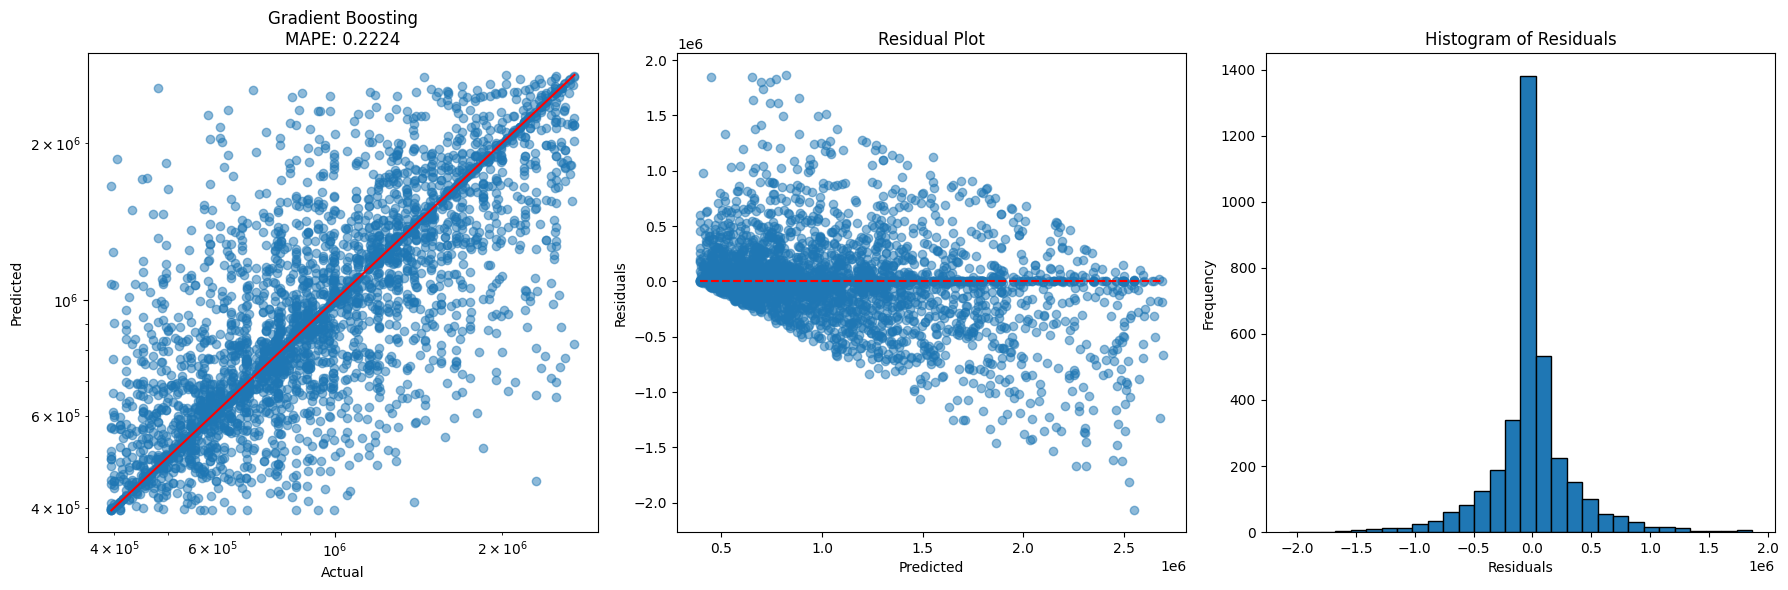

In [157]:
def gb_model(X_train, y_train, X_test, y_test, cv=5, max_depth=[None], learning_rate=[0.1]):
    """ Creates a Gradient Boosting model with grid search cv
    """
    gb = GradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [42]
    }

    grid_gb = GridSearchCV(gb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_gb.fit(X_train, y_train)

    best_params = grid_gb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_gb = grid_gb.predict(X_test)

    mape_gb = round(mean_absolute_percentage_error(y_test, y_pred_gb), 4)
    print('MAPE: {}'.format(mape_gb))

    r2_gb = round(r2_score(y_test, y_pred_gb), 4)
    print('R2: {}'.format(r2_gb))

    plt.figure(figsize=(18, 6))

    # Scatter plot of Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred_gb, alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="red")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting\nMAPE: {}'.format(mape_gb))
    plt.xscale("log")
    plt.yscale("log")

    # Residual plot
    residuals = y_test - y_pred_gb

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred_gb, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred_gb), max(y_pred_gb), colors='red', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Histogram of the residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')

    plt.tight_layout()
    plt.show()

    return grid_gb, mape_gb

gb_regression, mape_gb = gb_model(
    X_train,
    y_train,
    X_test,
    y_test,
    cv=5
)

mape_lst['Gradient Boosting'] = mape_gb

## Modelle vergleichen

In [158]:
sorted_mape_lst = dict(sorted(mape_lst.items(), key=lambda item: item[1]))
print(sorted_mape_lst)

{'XGBoost': 0.1783, 'Random Forest': 0.1892, 'Hist Gradient Boosting': 0.1962, 'Gradient Boosting': 0.2224, 'Multiple Linear Regression': 0.2731, 'Lasso Regression': 0.274, 'Ridge Regression': 0.2792}


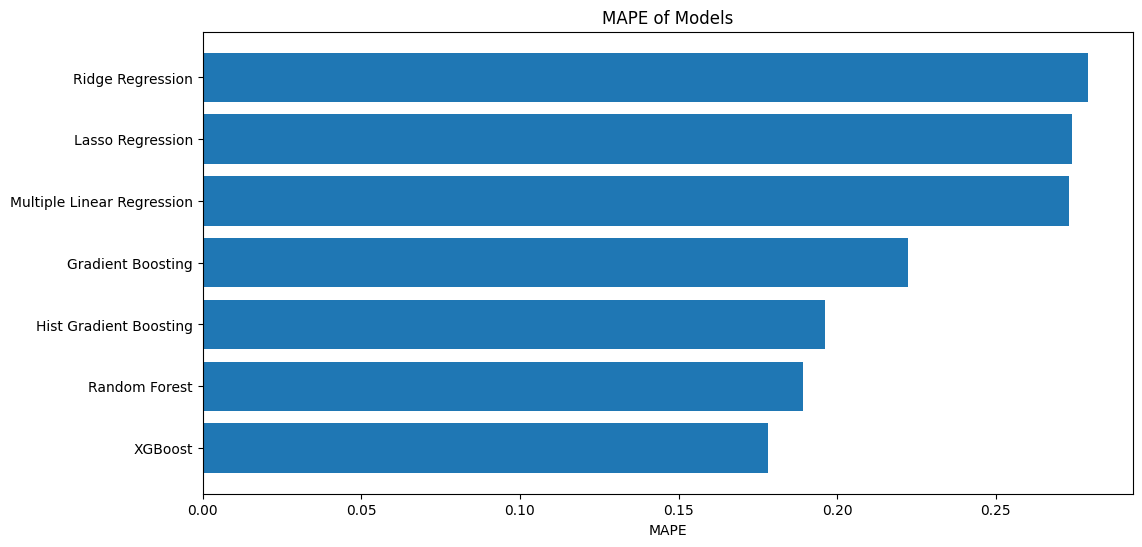

In [159]:
plt.figure(figsize=(12, 6))
plt.barh(list(sorted_mape_lst.keys()), list(sorted_mape_lst.values()))
plt.title('MAPE of Models')
plt.xlabel('MAPE')
plt.show()

In [160]:
X_test.head()

,Zip,Year built:,Living_area_unified,Floor_unified,Floor_space_merged,Plot_area_unified,Rooms_new,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,...,type_unified_stepped-apartment,type_unified_stepped-house,type_unified_studio,type_unified_terrace-house,type_unified_villa,Availability_Categorized_More than 6 months,Availability_Categorized_On request,Availability_Categorized_Within 1 month,Availability_Categorized_Within 3 months,Availability_Categorized_Within 6 months
0,-0.867644,1.021332,1.434491,0.902610,-0.643432,-0.530735,0.443038,0.732402,-0.581266,-0.371194,...,-0.102895,-0.052975,-0.029357,-0.165835,4.495728,1.200619,-0.857608,-0.214318,-0.067924,-0.039764
1,0.551266,-0.021299,-0.878897,-1.428159,-0.119957,-0.675211,-0.950429,-0.986796,0.586065,-0.188737,...,-0.102895,-0.052975,-0.029357,-0.165835,-0.222433,-0.832904,1.166034,-0.214318,-0.067924,-0.039764
2,-0.054784,-0.006818,-0.988190,0.514148,-1.248701,-0.048480,-0.950429,0.297879,2.618764,1.201437,...,-0.102895,-0.052975,-0.029357,-0.165835,-0.222433,-0.832904,-0.857608,-0.214318,-0.067924,-0.039764
3,-1.074877,-1.034968,-0.860681,-0.262775,-0.083150,0.025559,-0.950429,-0.306674,-0.602914,-0.356839,...,-0.102895,-0.052975,-0.029357,-0.165835,-0.222433,-0.832904,1.166034,-0.214318,-0.067924,-0.039764
4,-0.094116,0.985130,-0.095624,0.125687,0.550746,0.055175,-0.253696,-0.505043,-0.475801,-0.363442,...,-0.102895,-0.052975,-0.029357,-0.165835,-0.222433,-0.832904,1.166034,-0.214318,-0.067924,-0.039764


In [161]:
import pickle
filename = '../../99_gespeicherte_modelle/xgboost_model_big.sav'
pickle.dump(xgb_regression, open(filename, 'wb'))